In [1]:
import h5py
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import cv2
from tqdm.autonotebook import  tqdm
from einops import rearrange

/tmp/ipykernel_63706/1336894694.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import  tqdm


In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,root_path,num_samples,transform=None):
        self.root_path = root_path
        self.transform = transform
        self.num_samples = num_samples
        self.f = h5py.File(self.root_path,'r')
        self.data_length = len(self.f['y'][:num_samples])

        self.X_jets = self.f['X_jets'][:num_samples]
        self.y = self.f['y'][:num_samples]

        if self.transform:
            self.X_jets = self.transform(torch.as_tensor(np.array(self.X_jets)).permute(0,3,2,1))

        self.X_jets = (self.X_jets - self.X_jets.min())/(self.X_jets.max()-self.X_jets.min())
    def __getitem__(self,idx):
        X_jets = self.X_jets[idx]
        # mass = f['m0'][:1000][idx]
        # momentum = f['pt'][:1000][idx]
        y = self.y[idx]

        return torch.as_tensor(np.array(X_jets)),torch.as_tensor(np.array(y))

    def __len__(self):
        return self.data_length

In [3]:
path= '/home/pratyush/Desktop/diffusion/quark-gluon_data-set_n139306.hdf5'
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((128,128))])
data = Dataset(path,num_samples=8000,transform=transform)
dataloader = torch.utils.data.DataLoader(data,batch_size=64,num_workers=1,shuffle=True)

/home/pratyush/miniconda3/envs/clip/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [4]:
x_jets,y = next(iter(dataloader))

In [5]:
# for batch_size = data_length
print(torch.min(x_jets))
print(torch.max(x_jets))
print(torch.mean(x_jets))

tensor(0.)
tensor(0.1020)
tensor(1.4935e-05)


In [6]:
print(x_jets.shape)

torch.Size([64, 3, 128, 128])


tensor(1.)


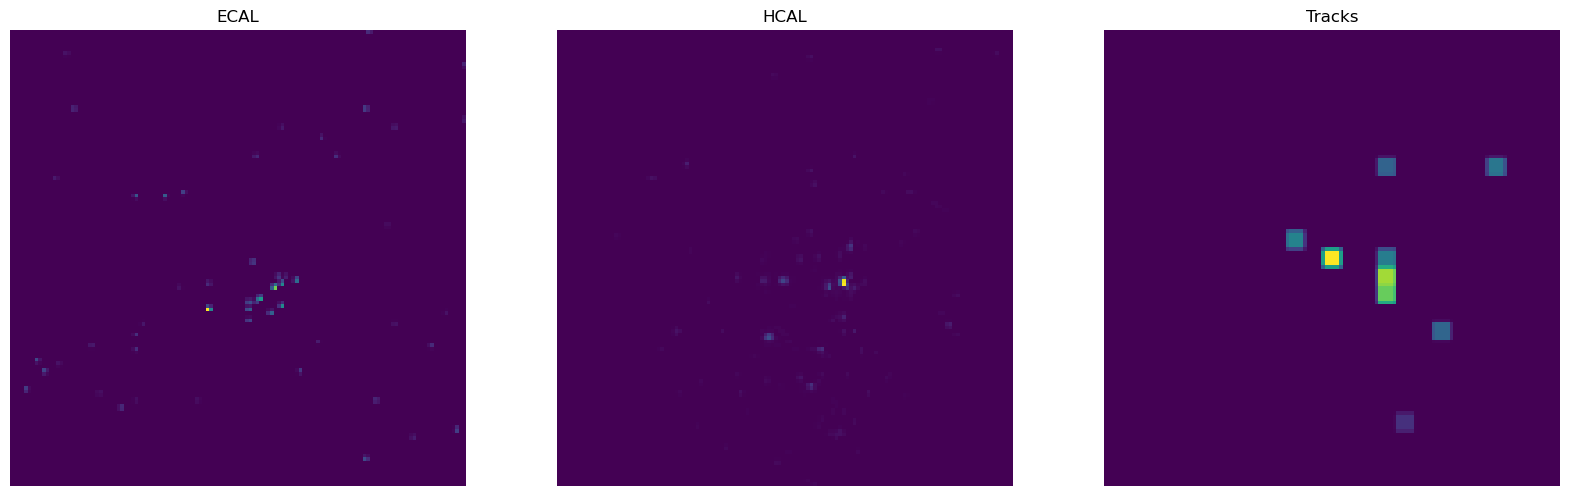

In [7]:
i = 15
print(y[i])
x_jets_np = x_jets.numpy()
fig,axs = plt.subplots(1,3,figsize = (20,20))
im1 = axs[0].imshow(x_jets_np[i,0,:,:])
axs[0].set_title('ECAL')
axs[0].axis('off')
im2 = axs[1].imshow(x_jets_np[i,1,:,:])
axs[1].set_title('HCAL')
axs[1].axis('off')
im3 = axs[2].imshow(x_jets_np[i,2,:,:])
axs[2].set_title('Tracks')
axs[2].axis('off')
# fig.colorbar(im1, ax=axs[0], shrink=0.25)
# fig.colorbar(im2, ax=axs[1], shrink=0.25)
# fig.colorbar(im3, ax=axs[2], shrink=0.25)

plt.show()

In [7]:
def vae_loss (encoder_inputs, outputs,z_mean,z_log_var):
    reconstruction_loss = nn.BCELoss()(encoder_inputs,outputs)
    # reconstruction_loss *= 128*128*3
    
    # kl_loss = 1+z_log_var - torch.square(z_mean)-torch.exp(z_log_var)
    # kl_loss = torch.mean(kl_loss,dim=1)
    # kl_loss *= -0.5
    # kl_loss = 1 + z_log_var - torch.square(z_mean) - torch.exp(z_log_var)
    # kl_loss = torch.sum(kl_loss, dim=1)  # Sum over dimensions
    # kl_loss = torch.mean(kl_loss) * -0.5
    # kl_loss = kl_loss.mean() 

    return reconstruction_loss

def sampling(args):
    z_mean,z_log_var = args
    batch = z_mean[0]
    dim= z_mean[1]
    eps = torch.randn(size =(batch,dim) )
    return z_mean + torch.exp(0.5*z_log_var)*eps
    

In [52]:
class AutoEncoder(nn.Module):
    def __init__(self,input_channels :int =3, base_channel_size: int = 32, latent_dim: int = 1024, 
                 act_fn:object = nn.GELU):


                super().__init__()
                c_hid = base_channel_size

                self.encoder_net = nn.Sequential(nn.Conv2d(input_channels,c_hid,kernel_size=3,padding=1,stride=2),
                act_fn(), #64*64
                nn.Conv2d(c_hid,c_hid,kernel_size=3,padding=1), 
                act_fn(),
                nn.Conv2d(c_hid,2*c_hid,kernel_size=3,padding=1,stride=2) , #32*32
                act_fn(),
                # nn.Conv2d(2*c_hid,2*c_hid,kernel_size=3,padding=1),
                # act_fn(),
                # nn.Conv2d(2*c_hid,2*c_hid,kernel_size=3,padding=1,stride=2),#16*16
                # act_fn(),
                nn.Flatten(),
                nn.Linear(2*32*32*c_hid,latent_dim)) 

                self.linear = nn.Sequential(nn.Linear(latent_dim,2*32*32*c_hid),
                act_fn())

                self.decoder_net = nn.Sequential(nn.ConvTranspose2d(2*c_hid,2*c_hid,kernel_size=3,output_padding=1,padding=1,stride=2),
                act_fn(),
                nn.Conv2d(2*c_hid,c_hid,kernel_size=3,padding=1),
                act_fn(),
                nn.ConvTranspose2d(c_hid,input_channels,kernel_size=3,output_padding=1,padding=1,stride=2),
                act_fn(),
                # nn.Conv2d(c_hid,c_hid,kernel_size=3,padding=1),
                # act_fn(),
                # nn.ConvTranspose2d(c_hid,input_channels,kernel_size=3,output_padding=1,padding=1,stride=2),
               )
     
    def forward(self,x):
        x = self.encoder_net(x)
        x = self.linear(x)
        x = x.reshape(x.shape[0],-1,32,32)
        x = self.decoder_net(x)

        return x

In [31]:
import torch
import torch.nn as nn

latent_dim = 1024

# Define the encoder model
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1) #[N,3,64,64]
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1) #[N,3,32,32]
        self.flatten = nn.Flatten() #[N,3*32*32]
        self.fc1 = nn.Linear(32 * 32 * 64, 1024)
        self.fc_z_mean = nn.Linear(1024, latent_dim)
        self.fc_z_log_var = nn.Linear(1024, latent_dim)
        
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        z_mean = self.fc_z_mean(x)
        z_log_var = self.fc_z_log_var(x)
        return z_mean, z_log_var

encoder = Encoder()

# Define the decoder model
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 32 * 32 * 64)
        # self.reshape = nn.View((64, 16, 16)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        # self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1)
        
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        # print(x.shape)
        x = x.reshape(32,64,32,32)
        x = nn.functional.relu(self.deconv1(x))
        # x = nn.functional.relu(self.deconv2(x))
        x = nn.functional.sigmoid(self.deconv3(x))
        return x

decoder = Decoder()

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mean + epsilon * std
        
    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, z_mean, z_log_var

vae = VAE(encoder, decoder)

# Print model summaries (PyTorch does not have a built-in summary function)
print(encoder)
print(decoder)
print(vae)

# Sample input shapes
sample_input = torch.randn(1, 3, 128, 128)
print(sample_input.shape)


Encoder(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=65536, out_features=1024, bias=True)
  (fc_z_mean): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_z_log_var): Linear(in_features=1024, out_features=1024, bias=True)
)
Decoder(
  (fc1): Linear(in_features=1024, out_features=65536, bias=True)
  (deconv1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv3): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)
VAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=65536, out_features=102

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoEncoder(latent_dim=1024).to(device)
# model = VAE(encoder,decoder).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)

In [55]:
torch.cuda.is_available()

True

In [58]:
num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    for x_jets,labels in tqdm(dataloader,total = len(dataloader)):
        x_jets = x_jets.to(device)
        optimizer.zero_grad()
        x_hat = model(x_jets)
        # print(x_hat.shape)
        # print(x_jets.shape)
        loss = criterion(x_jets,x_hat)
        loss.backward()
        total_loss+=loss.item()
        optimizer.step()
    torch.cuda.empty_cache()
    print(f'epoch: {epoch+1}, loss: {total_loss}')


100%|██████████| 250/250 [00:10<00:00, 24.62it/s]


epoch: 1, loss: 7.575526896630436e-05


100%|██████████| 250/250 [00:10<00:00, 24.75it/s]


epoch: 2, loss: 5.863411298889787e-05


100%|██████████| 250/250 [00:10<00:00, 24.68it/s]


epoch: 3, loss: 5.122889378128548e-05


100%|██████████| 250/250 [00:10<00:00, 24.66it/s]


epoch: 4, loss: 4.727704487805795e-05


100%|██████████| 250/250 [00:10<00:00, 24.64it/s]


epoch: 5, loss: 4.494594772808114e-05


100%|██████████| 250/250 [00:10<00:00, 24.56it/s]


epoch: 6, loss: 4.348883101812362e-05


100%|██████████| 250/250 [00:10<00:00, 24.60it/s]


epoch: 7, loss: 4.253143753629729e-05


100%|██████████| 250/250 [00:10<00:00, 24.62it/s]


epoch: 8, loss: 4.18584721231241e-05


100%|██████████| 250/250 [00:10<00:00, 24.62it/s]


epoch: 9, loss: 4.138936834152673e-05


100%|██████████| 250/250 [00:10<00:00, 24.40it/s]


epoch: 10, loss: 4.1139628606856604e-05


100%|██████████| 250/250 [00:10<00:00, 24.59it/s]


epoch: 11, loss: 5.311331263868624e-05


100%|██████████| 250/250 [00:10<00:00, 24.52it/s]


epoch: 12, loss: 5.238260816042839e-05


100%|██████████| 250/250 [00:10<00:00, 24.51it/s]


epoch: 13, loss: 5.3866329579932426e-05


100%|██████████| 250/250 [00:10<00:00, 24.52it/s]


epoch: 14, loss: 5.599197519501331e-05


100%|██████████| 250/250 [00:10<00:00, 24.51it/s]


epoch: 15, loss: 5.1533401027370473e-05


100%|██████████| 250/250 [00:10<00:00, 24.49it/s]


epoch: 16, loss: 5.6011351063034454e-05


100%|██████████| 250/250 [00:10<00:00, 24.42it/s]


epoch: 17, loss: 5.1954228119655e-05


100%|██████████| 250/250 [00:10<00:00, 24.47it/s]


epoch: 18, loss: 5.059748691138566e-05


100%|██████████| 250/250 [00:10<00:00, 24.49it/s]


epoch: 19, loss: 5.013507065854128e-05


100%|██████████| 250/250 [00:10<00:00, 24.47it/s]

epoch: 20, loss: 5.364818539277394e-05


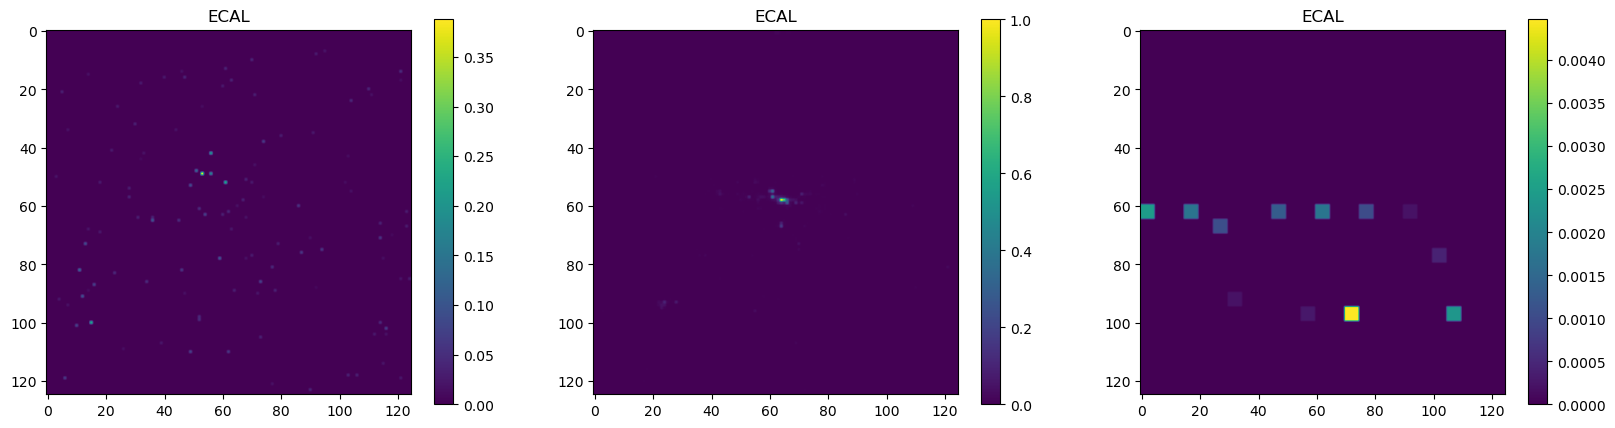

In [59]:
test_img = h5py.File(path,'r')['X_jets'][20000]
test_img = (test_img - test_img.min())/(test_img.max()-test_img.min())
fig,axs = plt.subplots(1,3,figsize = (20,20))
im1 = axs[0].imshow(test_img[:,:,0])
axs[0].set_title('ECAL')
im2 = axs[1].imshow(test_img[:,:,1])
axs[1].set_title('ECAL')
im3 = axs[2].imshow(test_img[:,:,2])
axs[2].set_title('ECAL')

fig.colorbar(im1, ax=axs[0], shrink=0.25)
fig.colorbar(im2, ax=axs[1], shrink=0.25)
fig.colorbar(im3, ax=axs[2], shrink=0.25)

plt.show()

In [60]:
test_img = torch.as_tensor(cv2.resize(test_img,(128,128))).unsqueeze(0)
test_img.shape

torch.Size([1, 128, 128, 3])

In [61]:
test_reconstructed = model(test_img.permute(0,3,1,2).to(device))

In [62]:
test_reconstructed.shape

torch.Size([1, 3, 128, 128])

In [1]:
fig,axs = plt.subplots(1,3,figsize = (20,20))
im1 = axs[0].imshow(test_reconstructed[0,0,:,:].detach().cpu().numpy())
axs[0].set_title('ECAL')
im2 = axs[1].imshow(test_reconstructed[0,1,:,:].detach().cpu().numpy())
axs[1].set_title('HCAL')
im3 = axs[2].imshow(test_reconstructed[0,2,:,:].detach().cpu().numpy())
axs[2].set_title('Tracks')

fig.colorbar(im1, ax=axs[0], shrink=0.25)
fig.colorbar(im2, ax=axs[1], shrink=0.25)
fig.colorbar(im3, ax=axs[2], shrink=0.25)

plt.show()

NameError: name 'plt' is not defined

In [1]:
import torch
import torch.nn as nn
import math
from functools import partial
from inspect import isfunction

def default(val, d):
    if val is not None:
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim,dim,kernel_size=4,stride=2,padding=1)

def Downsample(dim):
    return nn.Conv2d(dim,dim,kernel_size=4,stride=2,padding=1)

class SinusoidalPositionEmbedding(nn.Module):
    def __init__(self,dim):
        super().__init__()
        self.dim = dim

    def forward(self,time):
        device = time.device
        embeddings = math.log(10000)/( (self.dim//2) -1)
        embeddings = torch.exp(torch.arange(self.dim//2,device = device)* -embeddings)
        embeddings = time[:,None] * embeddings[None,:]
        embeddings = torch.cat((embeddings.sin(),embeddings.cos()),dim=-1)

        return embeddings

class Block(nn.Module):
    def __init__(self,dim,dim_output,groups=8):
        super().__init__()
        self.proj = nn.Conv2d(dim,dim_output,kernel_size = 3,padding=1)
        self.norm = nn.GroupNorm(groups,dim_output)
        self.act = nn.SiLU()

    def forward(self,x,scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if scale_shift is not None:
            scale,shift = scale_shift
            x = x * (scale+1) + shift

        x = self.act(x)

        return x

class ResNet(nn.Module):

    def __init__(self,dim,dim_output,time_emb=None,groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(),nn.Linear(time_emb,dim_output)
            if time_emb is not None else None)
        )

        self.block1 = Block(dim,dim_output,groups=groups)
        self.block2 = Block(dim_output,dim_output,groups=groups)
        self.res_conv = nn.Conv2d(dim,dim_output,1) if dim != dim_output else nn.Identity()


    def forward(self,x,time_emb = None):
        h = self.block1(x)

        if self.mlp is not None and time_emb is not None:
            time_emb = self.mlp(time_emb)
            h = time_emb.unsqueeze(-1).unsqueeze(-1) + h

        h = self.block2(h)

        return h + self.res_conv(x)

class ConvNextBlock(nn.Module):
    def __init__(self, dim, dim_output, time_emb=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb, dim))
            if time_emb is not None else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_output * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_output * mult),
            nn.Conv2d(dim_output * mult, dim_output, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_output, 1) if dim != dim_output else nn.Identity()


    def forward(self,x,time_emb = None):
        h = self.ds_conv(x)

        if self.mlp is not None and time_emb is not None:
            time_emb = self.mlp(time_emb)
            h = time_emb.unsqueeze(-1).unsqueeze(-1) + h

        h = self.net(h)

        return h + self.res_conv(x)


class Attention(nn.Module):
    def __init__(self,dim,num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5
        self.qkv = nn.Linear(dim,dim*3)
        self.proj = nn.Linear(dim,dim)

    def forward(self,x):
        # print(f'attention_Forward{x.shape}')
        B,C,H,W = x.shape
        qkv = self.qkv(x.permute(0,3,2,1)).reshape(B,H*W,3,self.num_heads,-1).permute(2,0,3,1,4)
        # print(f'qkv_Forward{x.shape}')
        q,k,v = qkv.reshape(3,B*self.num_heads,H*W,-1).unbind(0)

        attn = (q*self.scale) @ k.transpose(-2,-1)
        # print(f'attn_Forward{x.shape}')
        attn =attn.softmax(dim=-1)
        x = (attn @ v).view(B,self.num_heads,H,W,-1).permute(0,2,3,1,4).reshape(B,H,W,-1)
        # print(f'x_Forward{x.shape}')
        x = x.permute(0,3,2,1)
        return x 

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

class UNet(nn.Module):
    def __init__(self,dim,init_dim=None,output_dim=None,dim_mults = (1,2,4,8),
                 channels = 3,with_time_emb=True,resnet_block_group=8,use_convnext=True,
                 convnext_mult=2,
                ):

                super().__init__()

                self.channels = channels
                # init_dim = default(init_dim,dim //3 * 2) 
                init_dim = default(init_dim, dim // 3 * 2)

                self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)
                dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
                in_out = list(zip(dims[:-1], dims[1:]))

                if use_convnext:
                    block_class = partial(ConvNextBlock, mult=convnext_mult)
                else:
                    block_class = partial(ResnetBlock, groups=resnet_block_groups)

            
                if with_time_emb:
                    time_dim = dim * 4
                    self.time_mlp = nn.Sequential(
                    SinusoidalPositionEmbedding(dim),
                    nn.Linear(dim, time_dim),
                    nn.GELU(),
                    nn.Linear(time_dim, time_dim),
                )
                else:
                    time_dim = None
                    self.time_mlp = None

                self.downs = nn.ModuleList([])
                self.ups = nn.ModuleList([])
                num_resolutions = len(in_out)
                for ind, (dim_in, dim_out) in enumerate(in_out):
                    is_last = ind >= (num_resolutions - 1)

                    self.downs.append(
                        nn.ModuleList(
                            [
                                block_class(dim_in, dim_out, time_emb=time_dim),
                                block_class(dim_out, dim_out, time_emb=time_dim),
                                Residual(PreNorm(dim_out, Attention(dim_out))),
                                Downsample(dim_out) if not is_last else nn.Identity(),
                            ]
                        )
                    )

                mid_dim = dims[-1]
                self.mid_block1 = block_class(mid_dim, mid_dim, time_emb=time_dim)
                self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
                self.mid_block2 = block_class(mid_dim, mid_dim, time_emb=time_dim)

                for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
                    is_last = ind >= (num_resolutions - 1)

                    self.ups.append(
                        nn.ModuleList(
                            [
                                block_class(dim_out * 2, dim_in, time_emb=time_dim),
                                block_class(dim_in, dim_in, time_emb=time_dim),
                                Residual(PreNorm(dim_in, Attention(dim_in))),
                                Upsample(dim_in) if not is_last else nn.Identity(),
                            ]
                        )
                    )

                out_dim = default(output_dim, channels)
                self.final_conv = nn.Sequential(
                    block_class(dim, dim), nn.Conv2d(dim, out_dim, 1)
                )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if self.time_mlp is not None else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)    




torch.Size([4, 3, 64, 64])


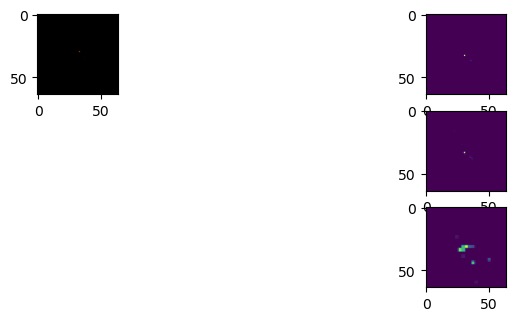

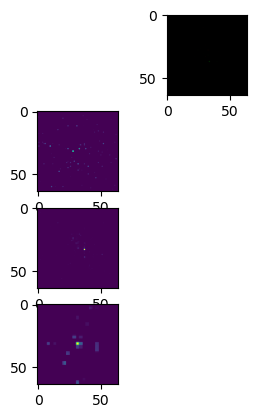

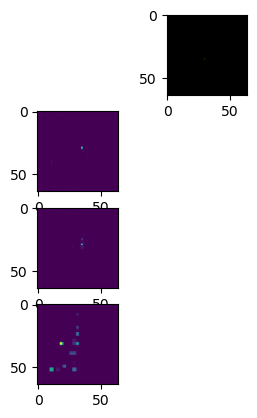

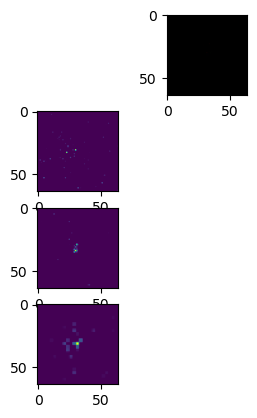

In [4]:
import torch
import torch.nn as nn
import torchvision
import sys
import os
sys.path += ['/home/pratyush/Desktop/diffusion/models/diffusion','..']
from dataset import Quark_Gluon_Dataset
from backward import UNet
from ddpm import DenoiseDiffusion_DDPM
import argparse
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt

# parser = argparse.ArgumentParser(description='Diffusion Training')

# parser.add_argument('--num_epochs',type=int,default=20,help = 'number of epochs')
# parser.add_argument('--T',type=int,default=200,help='number of time steps T')
# # parser.add_argument('--base_channel_size',type=int,default=32,help='size of base channel')
# parser.add_argument('--lr',type=float,default=3e-4,help='learning rate')
# parser.add_argument('--num_samples',type=int,default=10000,help='training data size')
# parser.add_argument('--batch_size',type=int,default=32,help = 'batch size')

# args = parser.parse_args()

#Dataset

path = '/home/pratyush/Desktop/diffusion'
os.makedirs(os.path.join(path,'testing'),exist_ok=True)
data_path = os.path.join(path,'quark-gluon_data-set_n139306.hdf5')
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((64,64))])
# transform=torchvision.transforms.Compose([
#         torchvision.transforms.ToTensor(),
#         torchvision.transforms.Resize((64,64)),
#         torchvision.transforms.Lambda(lambda t: (t * 2) - 1)
# ])

data = Quark_Gluon_Dataset(data_path,num_samples=4,transform=transform)
dataloader = torch.utils.data.DataLoader(data,batch_size=4,
                                         num_workers=1,shuffle=True)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(dim=128,channels=3,dim_mults=(1,2,4,)).to(device)
diffusion = DenoiseDiffusion_DDPM(model,800,device)

optimizer = torch.optim.Adam(model.parameters(),lr=3e-5)
jets,labels = next(iter(dataloader))
print(jets.shape)

for i in range(4):
    plt.subplot(4,4,i+1)
    plt.imshow(jets[i].permute(2,1,0))
    plt.subplot(4,4,i+4)
    plt.imshow(jets[i,0,:,:])
    plt.subplot(4,4,i+8)
    plt.imshow(jets[i,1,:,:])
    plt.subplot(4,4,i+12)
    plt.imshow(jets[i,2,:,:])
    plt.show()



In [9]:
os.makedirs(os.path.join(path,'testing'),exist_ok=True)
for epoch in range(50):
    total_loss = 0
    for step,(jets,labels) in enumerate(tqdm(dataloader,total = len(dataloader))):
        
        optimizer.zero_grad()
        loss,reconstructed = diffusion.loss(jets.to(device))
        loss.backward()
        total_loss+=loss.item()
        optimizer.step()

        if epoch % 5 == 0 and step % 4 ==0:
            plt.subplot(2,2,1)
            plt.imshow(reconstructed[0].permute(2,1,0).detach().cpu().numpy())
            plt.axis('off')
            plt.title('reconstructed_img')

            plt.subplot(2,2,2)
            plt.imshow(reconstructed[0,0,:,:].detach().cpu().numpy())
            plt.axis('off')
            plt.title('ECAL')

            plt.subplot(2,2,3)
            plt.imshow(reconstructed[0,1,:,:].detach().cpu().numpy())
            plt.axis('off')
            plt.title('HCAL')

            plt.subplot(2,2,4)
            plt.imshow(reconstructed[0,2,:,:].detach().cpu().numpy())
            plt.axis('off')
            plt.title('Tracks')
            plt.savefig(os.path.join(path,f'testing/ddpm_reconstructed_img_epoch{epoch}.jpeg'))
            plt.close()
            # print(batch[0][0].shape)
            plt.subplot(2,2,1)
            plt.imshow(jets[0].permute(2,1,0).detach().cpu().numpy())
            plt.axis('off')
            plt.title('img')

            plt.subplot(2,2,2)
            plt.imshow(jets[0,0,:,:].detach().cpu().numpy())
            plt.axis('off')
            plt.title('ECAL')

            plt.subplot(2,2,3)
            plt.imshow(jets[0,1,:,:].detach().cpu().numpy())
            plt.axis('off')
            plt.title('HCAL')

            plt.subplot(2,2,4)
            plt.imshow(jets[0,2,:,:].detach().cpu().numpy())
            plt.axis('off')
            plt.title('Tracks')

            plt.savefig(os.path.join(path,f'testing/ddpm_img_epoch{epoch}.jpeg'))
            plt.close()

    torch.cuda.empty_cache()
    print(f'epoch: {epoch+1}, loss: {total_loss}')

100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


epoch: 1, loss: 0.43177077174186707


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


epoch: 2, loss: 0.42533358931541443


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


epoch: 3, loss: 0.4209318161010742


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


epoch: 4, loss: 0.41958147287368774


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


epoch: 5, loss: 0.41838324069976807


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


epoch: 6, loss: 0.4240124821662903


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


epoch: 7, loss: 0.4126812219619751


100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


epoch: 8, loss: 0.4044426381587982


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


epoch: 9, loss: 0.4049108028411865


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


epoch: 10, loss: 0.41809457540512085


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


epoch: 11, loss: 0.39724063873291016


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


epoch: 12, loss: 0.3929063677787781


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


epoch: 13, loss: 0.3887919783592224


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


epoch: 14, loss: 0.38530248403549194


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


epoch: 15, loss: 0.38170886039733887


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


epoch: 16, loss: 0.3888767659664154


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


epoch: 17, loss: 0.38051170110702515


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


epoch: 18, loss: 0.4364132881164551


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


epoch: 19, loss: 0.37649568915367126


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


epoch: 20, loss: 0.4459800720214844


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


epoch: 21, loss: 0.4100048542022705


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


epoch: 22, loss: 0.3684083819389343


100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


epoch: 23, loss: 0.37603744864463806


100%|██████████| 1/1 [00:00<00:00,  4.35it/s]


epoch: 24, loss: 0.370680034160614


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


epoch: 25, loss: 0.364205539226532


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


epoch: 26, loss: 0.36776143312454224


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


epoch: 27, loss: 0.36093902587890625


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


epoch: 28, loss: 0.3525879979133606


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


epoch: 29, loss: 0.360506534576416


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


epoch: 30, loss: 0.3542179763317108


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


epoch: 31, loss: 0.34730836749076843


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


epoch: 32, loss: 0.3851552903652191


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


epoch: 33, loss: 0.345491886138916


100%|██████████| 1/1 [00:00<00:00,  4.26it/s]


epoch: 34, loss: 0.34320420026779175


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


epoch: 35, loss: 0.34298762679100037


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


epoch: 36, loss: 0.3377610445022583


100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


epoch: 37, loss: 0.33347392082214355


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


epoch: 38, loss: 0.3394875228404999


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


epoch: 39, loss: 0.33222150802612305


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


epoch: 40, loss: 0.32828187942504883


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


epoch: 41, loss: 0.3229915499687195


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


epoch: 42, loss: 0.3235338628292084


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


epoch: 43, loss: 0.3195064961910248


100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


epoch: 44, loss: 0.3209620714187622


100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


epoch: 45, loss: 0.3137059807777405


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


epoch: 46, loss: 0.36503466963768005


100%|██████████| 1/1 [00:00<00:00,  4.11it/s]


epoch: 47, loss: 0.3209637403488159


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


epoch: 48, loss: 0.31586602330207825


100%|██████████| 1/1 [00:00<00:00,  4.20it/s]


epoch: 49, loss: 0.40191763639450073


  0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 